In [6]:
import numpy as np
import pandas as pd
from pathlib import Path 
import json
import rasterio
import matplotlib.pyplot as plt

In [7]:
!mkdir models
!mkdir test_preds

In [2]:
img_path = "flair_aerial_train"
label_path = "flair_labels_train"
test_path = "flair_2_aerial_test"
sen_path = "flair_sen_train"
sen_test_path = "flair_2_sen_test"

pd.set_option('display.max_colwidth', None)

def list_items(path, filter): 
    for path in Path(path).rglob(filter): 
        yield path.resolve().as_posix() 

# aerial train
img_paths = sorted(list(list_items(img_path, "IMG*.tif")))
label_paths = sorted(list(list_items(label_path, "MSK*.tif")))
df = pd.DataFrame(list(zip(img_paths,label_paths)), columns=['img_path', 'label_path'])
df["area"] = df["img_path"].str.split('/').str[-4]
df["img_name"] = df["img_path"].str.split('/').str[-1]
df.to_csv("train.csv", index=False)

# aerial test
img_paths = sorted(list(list_items(test_path, "IMG*.tif")))
test_df = pd.DataFrame(list(img_paths), columns=['img_path'])
test_df["img_id"] = test_df["img_path"].str[-10:-4]
test_df["img_id"] = test_df["img_path"].str.split('/').str[-1]
test_df.to_csv("test.csv", index=False)

(512, 128, 3)


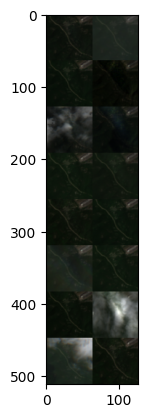

In [3]:
path = df.iloc[5003]["img_path"]
parts = path.split('/')
parts

idx_centroid = json.load(open("flair-2_centroids_sp_to_patch.json"))

sen_path = "flair_sen_train/"
sen_img_path = sen_path + parts[-4] +'/'+ parts[-3] + "/sen/SEN2_sp_" + parts[-4]+'-'+parts[-3]+"_data.npy"

x = np.load(sen_img_path)
indices = np.random.randint(x.shape[0], size=16) # take random 20
x = x[indices]

patch_size = 64 #112
a, b = idx_centroid[parts[-1]]
x = x[:,:3,::]
x = x[:,:,a-int(patch_size/2):a+int(patch_size/2),b-int(patch_size/2):b+int(patch_size/2)]

img_rows = []
for min_id in range(0, 16, 2):
    img_row = np.hstack([i for i in x[min_id:min_id+2]])
    img_rows.append(img_row.transpose(2, 1, 0))
img = np.vstack(img_rows)

# img = img.transpose(1, 2, 0)
img = img[:,:,::-1] #RGB
min, max = img.min(), img.max()
sen_img = (img - min) / (max - min)
print(sen_img.shape)
plt.imshow(sen_img);

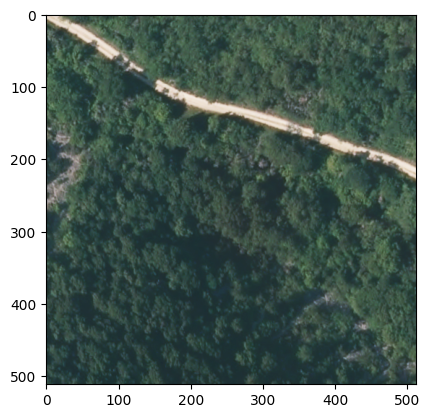

In [4]:
df = pd.read_csv("train.csv")
path = df.iloc[5003]["img_path"]
with rasterio.open(path) as image:
    img = np.array(image.read())[:3]

img = img.transpose(1, 2, 0)
plt.imshow(img);

(640, 512, 3)


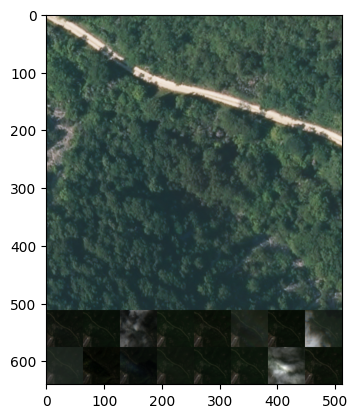

In [5]:
img = img / 255.0
new_img = np.vstack((img, sen_img.transpose(1,0,2)))
print(new_img.shape)
plt.imshow(new_img);